## Creacion de Modelos generales


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
#Carga de datos
comb_res_1 = pd.read_csv('/content/num_monsters_1_combat_results.csv')
#comb_res_2 = pd.read_csv('/content/num_monsters_2_combat_results.csv')
#comb_res_3 = pd.read_csv('/content/num_monsters_3_combat_results.csv')
comb_res_1.head()

,Unnamed: 0,pc1_class,pc1_level,pc1_hp_max,pc1_ac,pc1_STR,pc1_DEX,pc1_CON,pc1_INT,pc1_WIS,...,monster7_STR,monster7_DEX,monster7_CON,monster7_INT,monster7_WIS,monster7_CHA,winner,not_conscious_players_ratio,party_hp_ratio,difficulty
0,0,Bard,1,8,10,-1,-1,0,-1,-1,...,0,0,0,0,0,0,monsters,1.0,0.00,9
1,1,Bard,1,7,11,0,0,-1,3,0,...,0,0,0,0,0,0,monsters,1.0,0.00,9
2,2,Bard,1,8,12,3,1,0,-1,2,...,0,0,0,0,0,0,monsters,1.0,0.00,9
3,3,Bard,1,8,14,1,3,0,2,0,...,0,0,0,0,0,0,party,0.0,0.75,2
4,4,Bard,1,9,11,2,0,1,1,2,...,0,0,0,0,0,0,party,0.0,1.00,0


In [6]:
for col in comb_res_1.columns:
  print(col)

Unnamed: 0
pc1_class
pc1_level
pc1_hp_max
pc1_ac
pc1_STR
pc1_DEX
pc1_CON
pc1_INT
pc1_WIS
pc1_CHA
pc2_class
pc2_level
pc2_hp_max
pc2_ac
pc2_STR
pc2_DEX
pc2_CON
pc2_INT
pc2_WIS
pc2_CHA
pc3_class
pc3_level
pc3_hp_max
pc3_ac
pc3_STR
pc3_DEX
pc3_CON
pc3_INT
pc3_WIS
pc3_CHA
pc4_class
pc4_level
pc4_hp_max
pc4_ac
pc4_STR
pc4_DEX
pc4_CON
pc4_INT
pc4_WIS
pc4_CHA
pc5_class
pc5_level
pc5_hp_max
pc5_ac
pc5_STR
pc5_DEX
pc5_CON
pc5_INT
pc5_WIS
pc5_CHA
pc6_class
pc6_level
pc6_hp_max
pc6_ac
pc6_STR
pc6_DEX
pc6_CON
pc6_INT
pc6_WIS
pc6_CHA
pc7_class
pc7_level
pc7_hp_max
pc7_ac
pc7_STR
pc7_DEX
pc7_CON
pc7_INT
pc7_WIS
pc7_CHA
monster1_name
monster1_cr
monster1_hp_max
monster1_ac
monster1_STR
monster1_DEX
monster1_CON
monster1_INT
monster1_WIS
monster1_CHA
monster2_name
monster2_cr
monster2_hp_max
monster2_ac
monster2_STR
monster2_DEX
monster2_CON
monster2_INT
monster2_WIS
monster2_CHA
monster3_name
monster3_cr
monster3_hp_max
monster3_ac
monster3_STR
monster3_DEX
monster3_CON
monster3_INT
monster3_WIS
mons

In [12]:
comb_res_1['difficulty'].unique()

array([9, 2, 0, 3, 4, 5, 1, 7, 6])

Tenemos cargado nuestro dataframe con la informacion de las simulaciones de combate. Entonces, para dejar claro nuestro objetivo es predicir la dificultad de combate de una party con un monstruo.

Las dificultades son:
 - 0: Trivial
 - 1: Extremadamente facil
 - 2: Muy facil
 - 3: Facil
 - 4: Medio
 - 5: Dificl
 - 6: Mortal
 - 7: Muy mortal
 - 8: Extremadamente mortal
 - 9: Muerte segura

In [55]:
def entrenar_modelo_clasificacion(df, target_col, modelo, test_size=0.2, random_state=42):
    """
    Entrena un modelo de clasificación multiclase con preprocesamiento automático:
    - OneHot para categóricas
    - Escalado (StandardScaler) para numéricas

    Parámetros:
    - df: DataFrame completo
    - target_col: nombre de la columna objetivo
    - modelo: clasificador (LogisticRegression(), RandomForestClassifier(), etc.)
    - test_size: proporción del dataset para prueba
    - random_state: semilla para reproducibilidad

    Retorna:
    - pipeline entrenado
    - predicciones
    - X_train, X_test, y_train, y_test
    """

    # Eliminar columnas no necesarias
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Separar X e y
    X = df.drop(columns=[target_col])
    #y = df[target_col].astype(str)
    y = pd.Categorical(df[target_col]).codes

    # Identificar columnas categóricas y numéricas
    categorical_cols = [col for col in X.columns if X[col].dtype == "object"]
    numerical_cols = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]

    # Preprocesamiento combinado
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("num", StandardScaler(), numerical_cols)
        ],
        remainder="drop"  # solo usamos cat y num
    )

    if isinstance(modelo, LogisticRegression):
        modelo.set_params(max_iter=10000, solver='saga')

    # Pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", modelo)
    ])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Entrenamiento
    pipeline.fit(X_train, y_train)

    # Predicción
    y_pred = pipeline.predict(X_test)

    # Evaluación
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

    return pipeline, y_pred, X_train, X_test, y_train, y_test

In [40]:
def reentrenar_con_features_positivas(pipeline, X_train, y_train, clase_objetivo=0, top_n=None):
    """
    Reentrena un modelo de regresión logística usando solo las features con coeficientes positivos.

    Parámetros:
    - pipeline: pipeline original ya entrenado (con preprocessor + classifier)
    - X_train: DataFrame original de entrenamiento (no transformado)
    - y_train: etiquetas correspondientes
    - clase_objetivo: clase para la cual se interpretan los coeficientes (por defecto, clase 0)
    - top_n: si se desea limitar a las N features positivas más relevantes

    Retorna:
    - modelo reentrenado
    - DataFrame transformado filtrado
    - lista de features usadas
    """

    # Extraer componentes del pipeline
    modelo_lr = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']

    # Obtener nombres de columnas transformadas
    columnas_codificadas = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            columnas_codificadas.extend(transformer.get_feature_names_out(cols))
        elif name == 'num':
            columnas_codificadas.extend(cols)

    # Obtener coeficientes de la clase objetivo
    coeficientes = modelo_lr.coef_[clase_objetivo]
    importancia_df = pd.DataFrame({
        "feature": columnas_codificadas,
        "coef": coeficientes
    })

    # Filtrar solo coeficientes positivos
    positivas = importancia_df[importancia_df["coef"] > 0]
    if top_n:
        positivas = positivas.sort_values(by="coef", ascending=False).head(top_n)

    features_positivas = positivas["feature"].tolist()

    # Transformar X_train
    X_transformado = preprocessor.transform(X_train)
    if hasattr(X_transformado, "toarray"):  # sparse matrix a denso
        X_transformado = X_transformado.toarray()

    X_df = pd.DataFrame(X_transformado, columns=columnas_codificadas)
    X_filtrado = X_df[features_positivas]

    # Reentrenar solo con esas features
    nuevo_modelo = LogisticRegression(
        max_iter=10000,
        class_weight='balanced',
        solver='saga',
        penalty='l2'
    )
    nuevo_modelo.fit(X_filtrado, y_train)

    return nuevo_modelo, X_filtrado, features_positivas

In [20]:
def evaluar_importancia(modelo, X_train, y_train, X_test=None, y_test=None, top_n=20, metodo="feature_importance"):
    """
    Evaluar la importancia de las características (features) de un modelo.

    modelo: clasificador entrenado (por ejemplo, RandomForestClassifier, LogisticRegression)
    X_train: DataFrame con las características de entrenamiento
    y_train: etiquetas de entrenamiento
    X_test: DataFrame con las características de prueba (opcional, solo necesario para Permutation Importance)
    y_test: etiquetas de prueba (opcional, solo necesario para Permutation Importance)
    top_n: Número de las características más importantes a mostrar
    metodo: El método de evaluación a usar. Puede ser 'feature_importance', 'permutation', 'coeficientes', o 'shap'
    """

    # Entrenamos el modelo si no está entrenado
    if not hasattr(modelo, 'coef_') and not hasattr(modelo, 'feature_importances_'):
        modelo.fit(X_train, y_train)

    # Feature Importance - RandomForest, XGBoost, etc.
    if metodo == "feature_importance" and hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
        importancia_df = pd.DataFrame({
            "feature": X_train.columns,
            "importancia": importancias
        }).sort_values(by="importancia", ascending=False).head(top_n)

        # Visualizamos
        plt.figure(figsize=(10, 6))
        plt.barh(importancia_df["feature"], importancia_df["importancia"])
        plt.gca().invert_yaxis()
        plt.title(f"Top {top_n} Features más Importantes (Feature Importance)")
        plt.xlabel("Importancia")
        plt.show()
        return importancia_df

    # Permutation Importance - Se puede usar para cualquier modelo
    elif metodo == "permutation" and X_test is not None and y_test is not None:
        result = permutation_importance(modelo, X_test, y_test, n_repeats=10, random_state=42)
        sorted_idx = result.importances_mean.argsort()

        # Visualizamos
        plt.figure(figsize=(10, 6))
        plt.barh(X_test.columns[sorted_idx][-top_n:], result.importances_mean[sorted_idx][-top_n:])
        plt.title(f"Top {top_n} Features (Permutation Importance)")
        plt.show()
        return pd.DataFrame({
            "feature": X_test.columns[sorted_idx][-top_n:],
            "importancia": result.importances_mean[sorted_idx][-top_n:]
        })

    # Coeficientes - Para modelos lineales como Logistic Regression
    elif metodo == "coeficientes" and hasattr(modelo, 'coef_'):
        coeficientes = modelo.coef_[0]  # Si es clasificación binaria
        importancia_df = pd.DataFrame({
            "feature": X_train.columns,
            "coef": coeficientes
        }).sort_values(by="coef", key=abs, ascending=False).head(top_n)

        # Visualizamos
        plt.figure(figsize=(10, 6))
        plt.barh(importancia_df["feature"], importancia_df["coef"])
        plt.gca().invert_yaxis()
        plt.title(f"Top {top_n} Features (Coeficientes de Modelo Lineal)")
        plt.xlabel("Coeficiente")
        plt.show()
        return importancia_df

    # SHAP Values - Avanzado, para modelos de árboles (RandomForest, XGBoost)
    elif metodo == "shap" and hasattr(modelo, 'predict_proba'):
        explainer = shap.TreeExplainer(modelo)
        shap_values = explainer.shap_values(X_train)

        # Resumen gráfico de las características más importantes
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        return shap_values

    else:
        print("Método no válido o falta X_test y y_test para Permutation Importance.")
        return None

In [21]:
def evaluar_importancia_logistic_regression(modelo_pipeline, X_train, y_train, top_n=20):
    """
    Evalúa la importancia de las características de un modelo de regresión logística dentro de un pipeline.

    modelo_pipeline: sklearn Pipeline que contiene un ColumnTransformer y un LogisticRegression.
    X_train: DataFrame original antes de ser transformado.
    y_train: Etiquetas de entrenamiento.
    top_n: Número de características más importantes a mostrar.
    """

    # Obtener el modelo entrenado
    modelo_lr = modelo_pipeline.named_steps['classifier']

    # Obtener el preprocesador (ColumnTransformer)
    preprocessor = modelo_pipeline.named_steps['preprocessor']

    # Transformar los datos para obtener la misma forma que vio el modelo
    X_transformado = preprocessor.transform(X_train)

    # Obtener los nombres de las columnas transformadas
    # Primero, recogemos los nombres de las columnas codificadas por OneHotEncoder
    columnas_codificadas = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            columnas_codificadas.extend(transformer.get_feature_names_out(cols))
        elif name != 'remainder':
            columnas_codificadas.extend(cols)

    # Agregar columnas que fueron pasadas "tal cual" (remainder='passthrough')
    if preprocessor.remainder == 'passthrough':
        num_cols = [col for col in X_train.columns if col not in sum([cols for _, _, cols in preprocessor.transformers if _ != 'remainder'], [])]
        columnas_codificadas.extend(num_cols)

    # Ahora creamos el DataFrame con los coeficientes
    coeficientes = modelo_lr.coef_[0]  # Asumimos clasificación binaria
    importancia_df = pd.DataFrame({
        "feature": columnas_codificadas,
        "coef": coeficientes
    }).sort_values(by="coef", key=abs, ascending=False).head(top_n)

    # Visualización
    plt.figure(figsize=(10, 6))
    plt.barh(importancia_df["feature"], importancia_df["coef"])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Features más Importantes (Coeficientes de Modelo Logístico)")
    plt.xlabel("Coeficiente")
    plt.show()

    return importancia_df


In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def comparar_modelos(
    modelo_original, modelo_filtrado,
    preprocessor, X_test, y_test,
    features_filtradas, nombre_modelo_original="Original", nombre_modelo_filtrado="Positivas"
):
    """
    Compara el rendimiento entre dos modelos: uno completo y uno con features positivas.

    Parámetros:
    - modelo_original: pipeline con preprocesador + clasificador completo
    - modelo_filtrado: modelo reentrenado con features positivas (sin pipeline)
    - preprocessor: el preprocessor usado en el pipeline original
    - X_test, y_test: datos de prueba
    - features_filtradas: columnas transformadas usadas en el modelo filtrado
    - nombre_modelo_original, nombre_modelo_filtrado: nombres para mostrar

    Muestra:
    - Accuracy de ambos modelos
    - Reportes de clasificación
    - Matrices de confusión comparadas
    """

    # --- Modelo original (pipeline completo)
    y_pred_original = modelo_original.predict(X_test)
    acc_original = accuracy_score(y_test, y_pred_original)
    print(f"\n Modelo {nombre_modelo_original} - Accuracy: {acc_original:.3f}")
    print(classification_report(y_test, y_pred_original))

    # --- Modelo filtrado (requiere transformar y filtrar X_test igual que X_train)
    X_test_trans = preprocessor.transform(X_test)
    if hasattr(X_test_trans, "toarray"):
        X_test_trans = X_test_trans.toarray()
    col_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            col_names.extend(transformer.get_feature_names_out(cols))
        elif name == 'num':
            col_names.extend(cols)

    X_test_df = pd.DataFrame(X_test_trans, columns=col_names)
    X_test_filtrado = X_test_df[features_filtradas]

    y_pred_filtrado = modelo_filtrado.predict(X_test_filtrado)
    acc_filtrado = accuracy_score(y_test, y_pred_filtrado)
    print(f"\nModelo {nombre_modelo_filtrado} - Accuracy: {acc_filtrado:.3f}")
    print(classification_report(y_test, y_pred_filtrado))

    # --- Matrices de confusión
    cm1 = confusion_matrix(y_test, y_pred_original)
    cm2 = confusion_matrix(y_test, y_pred_filtrado)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title(f'Matriz Confusión: {nombre_modelo_original}')
    axs[0].set_xlabel('Predicción'); axs[0].set_ylabel('Real')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axs[1])
    axs[1].set_title(f'Matriz Confusión: {nombre_modelo_filtrado}')
    axs[1].set_xlabel('Predicción'); axs[1].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

Inicialmente, se intentara un modelo sencillo para ver el comportamiento de los datos, por lo que con la función creada. Usaremos el modelo de LogisticRegression con un maximo de 10,000 iteraciones.

In [35]:
modelo_lr_1, pred_lr_1, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(comb_res_1, "difficulty", LogisticRegression(max_iter=10000,class_weight="balanced",random_state=42))

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       376
           1       0.85      0.70      0.77       143
           2       0.52      0.75      0.62        32
           3       0.33      0.43      0.38         7
           4       0.33      0.25      0.29         4
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         2
           7       1.00      0.80      0.89         5
           9       1.00      1.00      1.00        19

    accuracy                           0.88       588
   macro avg       0.66      0.65      0.65       588
weighted avg       0.89      0.88      0.88       588

📊 Matriz de Confusión:
[[363  13   0   0   0   0   0   0   0]
 [ 24 100  19   0   0   0   0   0   0]
 [  0   4  24   4   0   0   0   0   0]
 [  0   0   3   3   1   0   0   0   0]
 [  0   0   0   2   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Como se puede observar, usando todas las caracterisitcas, no tiene un mal desenpeño en general, sin embargo, en la clasificacion de niveles desde el 2 al 5 se ve la deficiencia del modelo. Por lo que procedere a revisar, que columnas son las que mas aportan al modelo.

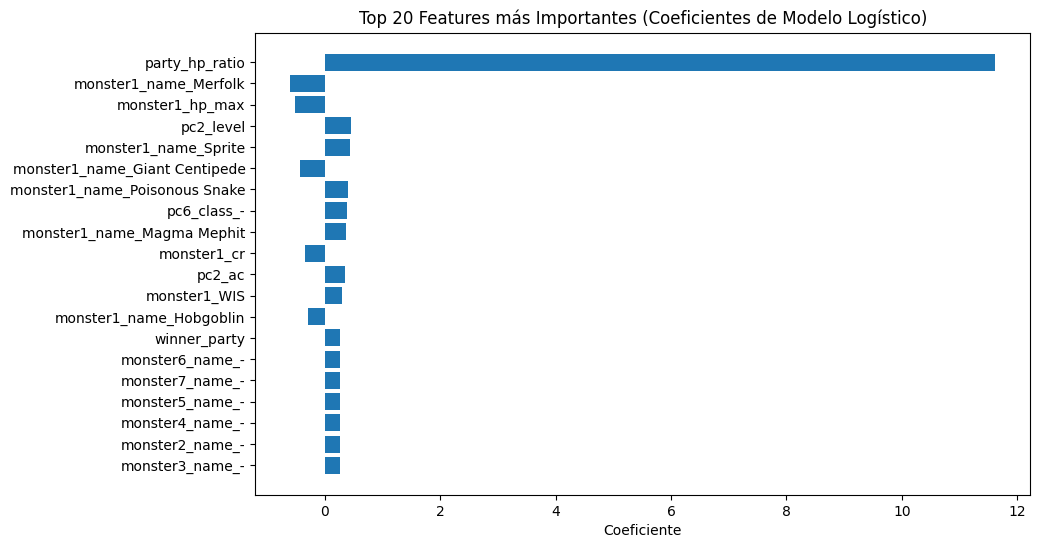

In [36]:
importancia_perm = evaluar_importancia_logistic_regression(modelo_lr_1, X_train, y_train)

Con solo ver el top 20 ya nos podemos hacer una idea del valor de cada columna, donde el valor que mas destaca es "party_hp_ratio" que seria la cantidad de vida que tiene la "party" y el resto de columnas aportan muy poco en comparacion, encontrando tambien valores negativos los cuales son valores categoricos como nombres de los monstruos.

Para comprobar si podemos mejorar el modelo quitando estos coeficientes negativos, haremos un modelo que tome las columnas positivas y solo entrene con las misma y haremos una comparación.

In [ ]:
modelo_reentrenado, X_filtrado, features_usadas = reentrenar_con_features_positivas(modelo_lr_1, X_train, y_train)


📊 Modelo Original - Accuracy: 0.878
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       376
           1       0.85      0.70      0.77       143
           2       0.52      0.75      0.62        32
           3       0.33      0.43      0.38         7
           4       0.33      0.25      0.29         4
           5       0.00      0.00      0.00         0
           6       1.00      1.00      1.00         2
           7       1.00      0.80      0.89         5
           9       1.00      1.00      1.00        19

    accuracy                           0.88       588
   macro avg       0.66      0.65      0.65       588
weighted avg       0.89      0.88      0.88       588


📊 Modelo Positivas - Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       376
           1       0.80      0.58      0.67       143
           2       0.38      0.34      0.36        32
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

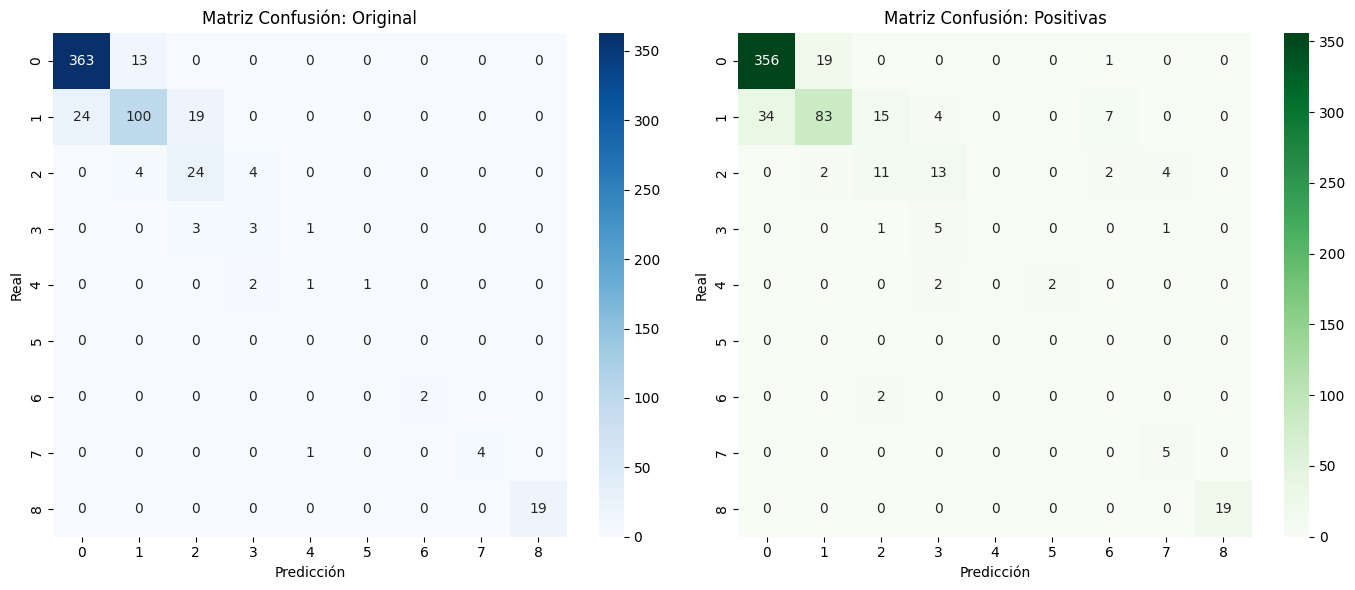

In [43]:
comparar_modelos(modelo_lr_1, modelo_reentrenado, modelo_lr_1.named_steps['preprocessor'], X_test, y_test, features_usadas)

Al parecer, esto no ayudo a un mejor modelo, ya que obtuvo un rendimiento menor a con todo el conjunto de datos, teniendo una precision menor en casi todas las predicciones de dificultad.

In [65]:
modelo_rf_1, pred_rf_1, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(comb_res_1, "difficulty",  RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       376
           1       0.92      0.79      0.85       143
           2       0.67      0.44      0.53        32
           3       1.00      0.29      0.44         7
           4       1.00      0.75      0.86         4
           6       0.00      0.00      0.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        19

    accuracy                           0.90       588
   macro avg       0.81      0.66      0.70       588
weighted avg       0.90      0.90      0.89       588

Matriz de Confusión:
[[375   1   0   0   0   0   0   0]
 [ 27 113   3   0   0   0   0   0]
 [ 10   8  14   0   0   0   0   0]
 [  1   0   4   2   0   0   0   0]
 [  1   0   0   0   3   0   0   0]
 [  1   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0  19]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
modelo_dg_1, pred_dg_1, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(comb_res_1, "difficulty",  XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:18:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       1.00      1.00      1.00       143
           2       1.00      0.94      0.97        32
           3       0.78      1.00      0.88         7
           4       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        19

    accuracy                           1.00       588
   macro avg       0.97      0.99      0.98       588
weighted avg       1.00      1.00      1.00       588

Matriz de Confusión:
[[376   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0  30   2   0   0   0   0]
 [  0   0   0   7   0   0   0   0]
 [  0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0  19]]


In [58]:
modelo_svg_1, pred_svg_1, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(comb_res_1, "difficulty",  SVC(kernel='rbf', class_weight='balanced', probability=True))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       376
           1       0.33      0.39      0.36       143
           2       0.36      0.81      0.50        32
           3       0.67      0.57      0.62         7
           4       1.00      1.00      1.00         4
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        19

    accuracy                           0.63       588
   macro avg       0.77      0.74      0.73       588
weighted avg       0.68      0.63      0.64       588

Matriz de Confusión:
[[254 111  11   0   0   0   0   0]
 [ 55  56  32   0   0   0   0   0]
 [  1   3  26   2   0   0   0   0]
 [  0   0   3   4   0   0   0   0]
 [  0   0   0   0   4   0   0   0]
 [  0   1   0   0   0   1   0   0]
 [  0   0   0   0   0   0   5   0]
 [  0   0   0   0   0   0   0  19]]


In [53]:
modelo_knn_1, pred_knn_1, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(comb_res_1, "difficulty",  KNeighborsClassifier(n_neighbors=5))

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       376
           1       0.33      0.23      0.27       143
           2       0.37      0.22      0.27        32
           3       0.33      0.14      0.20         7
           4       1.00      0.25      0.40         4
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         2
           7       1.00      0.40      0.57         5
           9       0.95      1.00      0.97        19

    accuracy                           0.65       588
   macro avg       0.52      0.34      0.39       588
weighted avg       0.61      0.65      0.62       588

📊 Matriz de Confusión:
[[317  57   2   0   0   0   0   0   0]
 [105  33   5   0   0   0   0   0   0]
 [ 15  10   7   0   0   0   0   0   0]
 [  2   0   4   1   0   0   0   0   0]
 [  0   0   0   2   1   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  2   0 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_